# 🏠 Local EmbeddingGemma for On-Device Embeddings

This notebook tests EmbeddingGemma for offline, on-device embedding generation as an alternative to Google Gemini API.

## What This Notebook Does:
- Tests EmbeddingGemma model locally without API limits
- Compares performance with Google Gemini API and TF-IDF embeddings
- Generates embeddings for the full IFC publication database
- Evaluates embedding quality and clustering results
- Provides a completely offline solution for embedding generation

## 1. Setup and Installation

In [1]:
# Install required packages for EmbeddingGemma
!pip install -U sentence-transformers transformers torch
!pip install accelerate bitsandbytes  # For efficient model loading

print("✅ EmbeddingGemma dependencies installed!")

  Using cached tokenizers-0.22.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 13.8 MB/s  0:00:00m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 54.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.0/888.0 MB 32.5 MB/s  0:00:23m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 33.0 MB/s  0:00:16m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 35.3 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 36.8 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 38.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 31.0 MB/s  0:00:18m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 32.9 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
# Core imports
import json
import pandas as pd
import numpy as np
import torch
from datetime import datetime
import os
from pathlib import Path
import time

# EmbeddingGemma specific
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

# Visualization and analysis
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML tools
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import umap
from tqdm.auto import tqdm

print("✅ All imports successful!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🖥️ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name()}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

✅ All imports successful!
🔥 PyTorch version: 2.8.0+cu128
🖥️ CUDA available: True
🎮 GPU: NVIDIA GeForce RTX 3050 Laptop GPU
💾 GPU Memory: 4.0 GB


## 2. Load EmbeddingGemma Model

We'll load the EmbeddingGemma model for local inference. This model runs entirely offline once downloaded.

In [4]:
# Login into Hugging Face Hub
from huggingface_hub import login
login()

In [2]:
# Add this before trying to load the model
print("🚨 IMPORTANT: EmbeddingGemma Access Required")
print("=" * 50)
print("Before running this notebook, you need to:")
print("1. Visit: https://huggingface.co/google/embeddinggemma-300M")
print("2. Click 'Request access' and accept the license agreement")
print("3. Wait for approval (usually takes a few minutes)")
print("4. Make sure you're logged in with the correct token")
print()
print("Current login status check...")

# Check if you're properly logged in
from huggingface_hub import whoami
try:
    user_info = whoami()
    print(f"✅ Logged in as: {user_info['name']}")
except:
    print("❌ Not logged in to Hugging Face Hub")
    print("Please run: huggingface-cli login")

🚨 IMPORTANT: EmbeddingGemma Access Required
Before running this notebook, you need to:
1. Visit: https://huggingface.co/google/embeddinggemma-300M
2. Click 'Request access' and accept the license agreement
3. Wait for approval (usually takes a few minutes)
4. Make sure you're logged in with the correct token

Current login status check...
✅ Logged in as: mapkinase


In [2]:
# Setup device and model configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🔧 Using device: {device}")

# EmbeddingGemma model ID
model_id = "google/embeddinggemma-300M"  # 300M parameter model for efficiency

print(f"📥 Loading EmbeddingGemma model: {model_id}")
print("⏳ This may take a few minutes for first-time download...")

try:
    # Load model using SentenceTransformers (easier interface)
    start_time = time.time()
    
    model = SentenceTransformer(model_id, device=device)
    
    load_time = time.time() - start_time
    
    print(f"✅ EmbeddingGemma loaded successfully in {load_time:.1f} seconds")
    print(f"🎯 Model device: {model.device}")
    print(f"📊 Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
except Exception as e:
    print(f"❌ Error loading EmbeddingGemma: {e}")
    print("\n💡 Note: You may need to accept the Gemma license at:")
    print("https://huggingface.co/google/embeddinggemma-300M")
    print("And login to Hugging Face Hub: huggingface-cli login")
    raise

🔧 Using device: cuda
📥 Loading EmbeddingGemma model: google/embeddinggemma-300M
⏳ This may take a few minutes for first-time download...
✅ EmbeddingGemma loaded successfully in 9.4 seconds
🎯 Model device: cuda:0
📊 Model parameters: 307,581,696


## 3. Test EmbeddingGemma with Sample Data

In [6]:
# Test embeddings with sample scientific texts
print("🧪 Testing EmbeddingGemma with sample scientific texts...")

# Sample texts similar to IFC publications
test_texts = [
    "Cellular physiology and ion channel function in cardiac myocytes",
    "Neuroscience research on synaptic transmission and neural plasticity",
    "Molecular biology of protein folding and enzymatic catalysis",
    "Cardiovascular research on heart failure and cardiac arrhythmias",
    "Biomedical engineering applications in medical device development"
]

# Task prompt for semantic similarity (as per EmbeddingGemma documentation)
task_name = "STS"  # Semantic Textual Similarity

print(f"📝 Processing {len(test_texts)} test texts...")
start_time = time.time()

# Generate embeddings
test_embeddings = model.encode(test_texts, prompt=task_name, show_progress_bar=True)

processing_time = time.time() - start_time

print(f"✅ Test embeddings generated!")
print(f"📊 Embedding shape: {test_embeddings.shape}")
print(f"⚡ Processing time: {processing_time:.2f} seconds")
print(f"📈 Speed: {len(test_texts)/processing_time:.1f} texts/second")
print(f"🔢 Embedding dimension: {test_embeddings.shape[1]}")
print(f"📋 First embedding preview: {test_embeddings[0][:5]}")

🧪 Testing EmbeddingGemma with sample scientific texts...
📝 Processing 5 test texts...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Test embeddings generated!
📊 Embedding shape: (5, 768)
⚡ Processing time: 0.25 seconds
📈 Speed: 20.1 texts/second
🔢 Embedding dimension: 768
📋 First embedding preview: [-0.12043052 -0.02111813  0.02104381 -0.00133736 -0.03709357]


🔍 Testing similarity calculation...


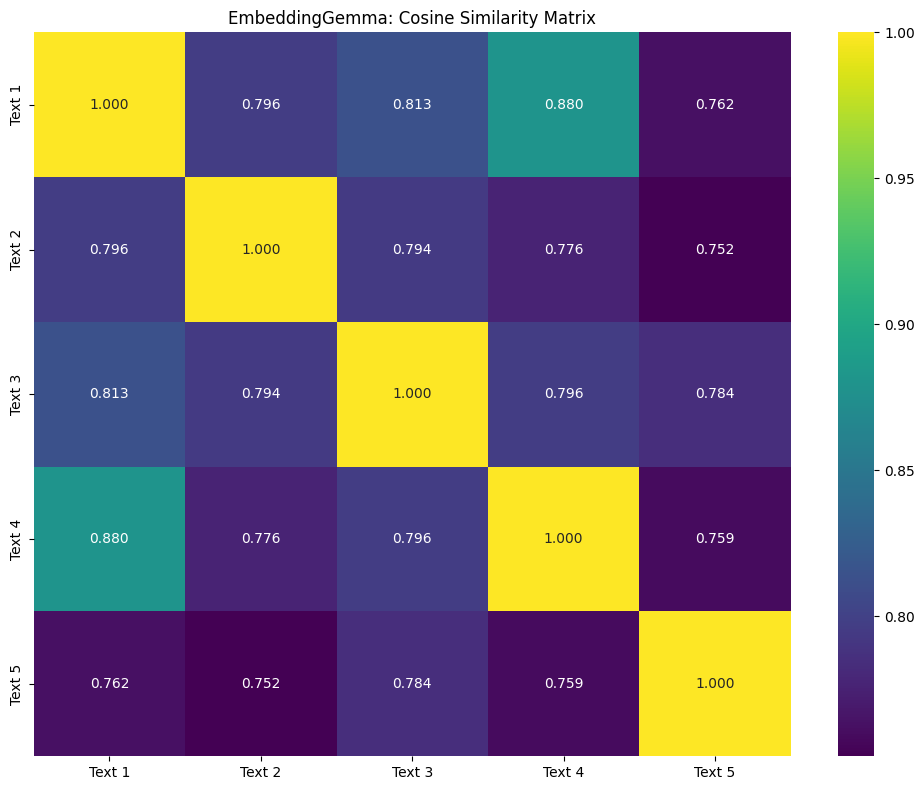


🏆 Most similar text pairs:
  • Text 1 ↔ Text 2: 0.796
    'Cellular physiology and ion channel function in ca...'
    'Neuroscience research on synaptic transmission and...'

  • Text 1 ↔ Text 3: 0.813
    'Cellular physiology and ion channel function in ca...'
    'Molecular biology of protein folding and enzymatic...'

  • Text 1 ↔ Text 4: 0.880
    'Cellular physiology and ion channel function in ca...'
    'Cardiovascular research on heart failure and cardi...'

  • Text 1 ↔ Text 5: 0.762
    'Cellular physiology and ion channel function in ca...'
    'Biomedical engineering applications in medical dev...'

  • Text 2 ↔ Text 3: 0.794
    'Neuroscience research on synaptic transmission and...'
    'Molecular biology of protein folding and enzymatic...'

  • Text 2 ↔ Text 4: 0.776
    'Neuroscience research on synaptic transmission and...'
    'Cardiovascular research on heart failure and cardi...'

  • Text 2 ↔ Text 5: 0.752
    'Neuroscience research on synaptic transmission and..

In [5]:
# Test similarity calculation
print("🔍 Testing similarity calculation...")

# Calculate pairwise similarities
similarities = cosine_similarity(test_embeddings)

# Create similarity heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarities, 
            annot=True, 
            fmt='.3f',
            cmap='viridis',
            xticklabels=[f"Text {i+1}" for i in range(len(test_texts))],
            yticklabels=[f"Text {i+1}" for i in range(len(test_texts))])
plt.title('EmbeddingGemma: Cosine Similarity Matrix')
plt.tight_layout()
plt.show()

# Show most similar pairs
print("\n🏆 Most similar text pairs:")
for i in range(len(test_texts)):
    for j in range(i+1, len(test_texts)):
        sim = similarities[i, j]
        if sim > 0.5:  # Threshold for "similar"
            print(f"  • Text {i+1} ↔ Text {j+1}: {sim:.3f}")
            print(f"    '{test_texts[i][:50]}...'")
            print(f"    '{test_texts[j][:50]}...'")
            print()

## 4. Load IFC Publication Database

In [3]:
# Load the expanded IFC database
database_path = 'data/processed/expanded_ifc_publications.json'

try:
    with open(database_path, 'r', encoding='utf-8') as f:
        database_data = json.load(f)
    
    publications = database_data['publications']
    metadata = database_data['metadata']
    
    print(f"📚 Loaded {len(publications)} publications from expanded database")
    print(f"📊 Database metadata:")
    print(f"   • Total publications: {metadata['total_publications']}")
    print(f"   • Original IFC articles: {metadata['sources']['original_ifc_scraping']}")
    print(f"   • PubMed articles: {metadata['sources']['pubmed_filtered_search']}")
    
except FileNotFoundError:
    print("❌ Expanded database not found. Please run the database expansion notebook first.")
    print("Expected file: data/processed/expanded_ifc_publications.json")
    raise

# Convert to DataFrame
df = pd.DataFrame(publications)

# Add source type
df['source_type'] = df['metadata'].apply(
    lambda x: 'PubMed' if x.get('source') == 'PubMed_filtered_search' else 'IFC'
)

# Create embedding text
df['embedding_text'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')
df['embedding_text'] = df['embedding_text'].str.strip()

# Filter valid texts
df_embed = df[df['embedding_text'].str.len() > 10].copy()

print(f"\n📊 Dataset for embedding:")
print(f"   • Total articles: {len(df_embed)}")
print(f"   • IFC articles: {len(df_embed[df_embed['source_type'] == 'IFC'])}")
print(f"   • PubMed articles: {len(df_embed[df_embed['source_type'] == 'PubMed'])}")
print(f"   • Year range: {df_embed['year'].min()} - {df_embed['year'].max()}")

📚 Loaded 852 publications from expanded database
📊 Database metadata:
   • Total publications: 852
   • Original IFC articles: 0
   • PubMed articles: 852

📊 Dataset for embedding:
   • Total articles: 851
   • IFC articles: 0
   • PubMed articles: 851
   • Year range: 1992 - 2025


## 5. Generate EmbeddingGemma Embeddings for Full Database

In [4]:
# Generate embeddings for the full database
print("🚀 Generating EmbeddingGemma embeddings for full database...")
print(f"📊 Processing {len(df_embed)} articles")

def generate_embeddinggemma_embeddings(df, model, task_name="STS", batch_size=32):
    """
    Generate EmbeddingGemma embeddings with batching for efficiency
    """
    texts = df['embedding_text'].tolist()
    total_texts = len(texts)
    
    print(f"🔄 Processing {total_texts} texts in batches of {batch_size}")
    
    # Track memory usage if on GPU
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        initial_memory = torch.cuda.memory_allocated() / 1e9
        print(f"💾 Initial GPU memory: {initial_memory:.2f} GB")
    
    start_time = time.time()
    
    # Process in batches to manage memory
    all_embeddings = []
    
    for i in tqdm(range(0, total_texts, batch_size), desc="Processing batches"):
        batch_end = min(i + batch_size, total_texts)
        batch_texts = texts[i:batch_end]
        
        # Generate embeddings for this batch
        with torch.no_grad():  # Save memory
            batch_embeddings = model.encode(
                batch_texts, 
                prompt=task_name,
                show_progress_bar=False,
                convert_to_numpy=True
            )
        
        all_embeddings.append(batch_embeddings)
        
        # Memory management
        if torch.cuda.is_available() and i % (batch_size * 10) == 0:
            torch.cuda.empty_cache()
            current_memory = torch.cuda.memory_allocated() / 1e9
            if i > 0:
                elapsed = time.time() - start_time
                rate = (i + len(batch_texts)) / elapsed
                eta = (total_texts - i - len(batch_texts)) / rate / 60
                print(f"   📈 Batch {i//batch_size + 1}: {current_memory:.2f} GB GPU, {rate:.1f} texts/sec, ETA: {eta:.1f}min")
    
    # Combine all embeddings
    embeddings = np.vstack(all_embeddings)
    
    processing_time = time.time() - start_time
    
    print(f"\n✅ EmbeddingGemma embeddings completed!")
    print(f"📊 Generated {len(embeddings)} embeddings")
    print(f"🔢 Embedding dimension: {embeddings.shape[1]}")
    print(f"⏱️ Total time: {processing_time/60:.1f} minutes")
    print(f"⚡ Average speed: {len(embeddings)/processing_time:.1f} texts/second")
    
    if torch.cuda.is_available():
        final_memory = torch.cuda.memory_allocated() / 1e9
        print(f"💾 Final GPU memory: {final_memory:.2f} GB")
    
    return embeddings

# Generate embeddings
gemma_embeddings = generate_embeddinggemma_embeddings(
    df_embed, 
    model, 
    task_name="STS", 
    batch_size=16  # Adjust based on your GPU memory
)

# Add embeddings to dataframe
df_embed['embedding'] = [emb for emb in gemma_embeddings]

print(f"\n🎯 Ready for analysis with {len(df_embed)} articles and EmbeddingGemma embeddings!")

🚀 Generating EmbeddingGemma embeddings for full database...
📊 Processing 851 articles
🔄 Processing 851 texts in batches of 16
💾 Initial GPU memory: 1.23 GB


Processing batches:   0%|          | 0/54 [00:00<?, ?it/s]

   📈 Batch 11: 1.24 GB GPU, 14.8 texts/sec, ETA: 0.8min
   📈 Batch 21: 1.24 GB GPU, 14.7 texts/sec, ETA: 0.6min
   📈 Batch 31: 1.24 GB GPU, 14.6 texts/sec, ETA: 0.4min
   📈 Batch 41: 1.24 GB GPU, 14.7 texts/sec, ETA: 0.2min
   📈 Batch 51: 1.24 GB GPU, 15.0 texts/sec, ETA: 0.0min

✅ EmbeddingGemma embeddings completed!
📊 Generated 851 embeddings
🔢 Embedding dimension: 768
⏱️ Total time: 0.9 minutes
⚡ Average speed: 15.0 texts/second
💾 Final GPU memory: 1.24 GB

🎯 Ready for analysis with 851 articles and EmbeddingGemma embeddings!


## 6. Save EmbeddingGemma Embeddings

In [8]:
# Save EmbeddingGemma embeddings and metadata
output_dir = 'data/processed'
os.makedirs(output_dir, exist_ok=True)

gemma_embeddings_file = f'{output_dir}/embeddinggemma_publication_embeddings.npy'
gemma_meta_file = f'{output_dir}/embeddinggemma_publication_embeddings_meta.json'

# Save embeddings
np.save(gemma_embeddings_file, gemma_embeddings)

# Save metadata
gemma_meta = {
    'model': model_id,
    'model_type': 'EmbeddingGemma',
    'generated_at': datetime.now().isoformat(),
    'total_embeddings': len(gemma_embeddings),
    'embedding_dimension': gemma_embeddings.shape[1],
    'processing_mode': 'local_offline',
    'articles_processed': len(df_embed),
    'device': device,
    'task_prompt': task_name,
    'batch_processing': True,
    'model_parameters': sum(p.numel() for p in model.parameters()),
    'processing_speed_texts_per_second': len(gemma_embeddings) / processing_time,
    'dataset_info': {
        'ifc_articles': len(df_embed[df_embed['source_type'] == 'IFC']),
        'pubmed_articles': len(df_embed[df_embed['source_type'] == 'PubMed']),
        'year_range': [int(df_embed['year'].min()), int(df_embed['year'].max())]
    }
}

with open(gemma_meta_file, 'w') as f:
    json.dump(gemma_meta, f, indent=2)

print(f"💾 EmbeddingGemma embeddings saved:")
print(f"   • Embeddings: {gemma_embeddings_file}")
print(f"   • Metadata: {gemma_meta_file}")
print(f"📊 File sizes:")
print(f"   • Embeddings: {os.path.getsize(gemma_embeddings_file) / 1e6:.1f} MB")
print(f"   • Metadata: {os.path.getsize(gemma_meta_file) / 1e3:.1f} KB")

💾 EmbeddingGemma embeddings saved:
   • Embeddings: data/processed/embeddinggemma_publication_embeddings.npy
   • Metadata: data/processed/embeddinggemma_publication_embeddings_meta.json
📊 File sizes:
   • Embeddings: 2.6 MB
   • Metadata: 0.5 KB


## 7. Dimensionality Reduction and Visualization

In [9]:
# Prepare embeddings matrix
embeddings_matrix = np.stack(df_embed['embedding'].values)
print(f"📊 Embeddings matrix shape: {embeddings_matrix.shape}")

# t-SNE visualization
print("🔄 Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
tsne_results = tsne.fit_transform(embeddings_matrix)

df_embed['tsne_x'] = tsne_results[:, 0]
df_embed['tsne_y'] = tsne_results[:, 1]

print("✅ t-SNE completed")

# UMAP visualization
print("🔄 Computing UMAP...")
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_results = umap_reducer.fit_transform(embeddings_matrix)

df_embed['umap_x'] = umap_results[:, 0]
df_embed['umap_y'] = umap_results[:, 1]

print("✅ UMAP completed")

📊 Embeddings matrix shape: (851, 768)
🔄 Computing t-SNE...
✅ t-SNE completed
🔄 Computing UMAP...


/home/santi/Projects/UBMI-IFC-Podcast/venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/santi/Projects/UBMI-IFC-Podcast/venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:373: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


✅ UMAP completed


In [10]:
# Create interactive visualizations
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("t-SNE (EmbeddingGemma)", "UMAP (EmbeddingGemma)"),
    specs=[[{"type": "scatter"}, {"type": "scatter"}]]
)

# t-SNE plot
for source in ['IFC', 'PubMed']:
    mask = df_embed['source_type'] == source
    fig.add_trace(
        go.Scatter(
            x=df_embed[mask]['tsne_x'],
            y=df_embed[mask]['tsne_y'],
            mode='markers',
            name=f'{source}',
            text=df_embed[mask]['title'],
            hoverinfo='text',
            marker=dict(size=6, opacity=0.7)
        ),
        row=1, col=1
    )

# UMAP plot
for source in ['IFC', 'PubMed']:
    mask = df_embed['source_type'] == source
    fig.add_trace(
        go.Scatter(
            x=df_embed[mask]['umap_x'],
            y=df_embed[mask]['umap_y'],
            mode='markers',
            name=f'{source}',
            text=df_embed[mask]['title'],
            hoverinfo='text',
            marker=dict(size=6, opacity=0.7),
            showlegend=False
        ),
        row=1, col=2
    )

fig.update_layout(
    title_text="EmbeddingGemma: Publication Embeddings Visualization",
    height=600,
    width=1200
)

fig.show()

print("📊 EmbeddingGemma visualizations generated!")

📊 EmbeddingGemma visualizations generated!


## 8. Clustering Analysis

🔄 Performing K-means clustering on EmbeddingGemma embeddings...


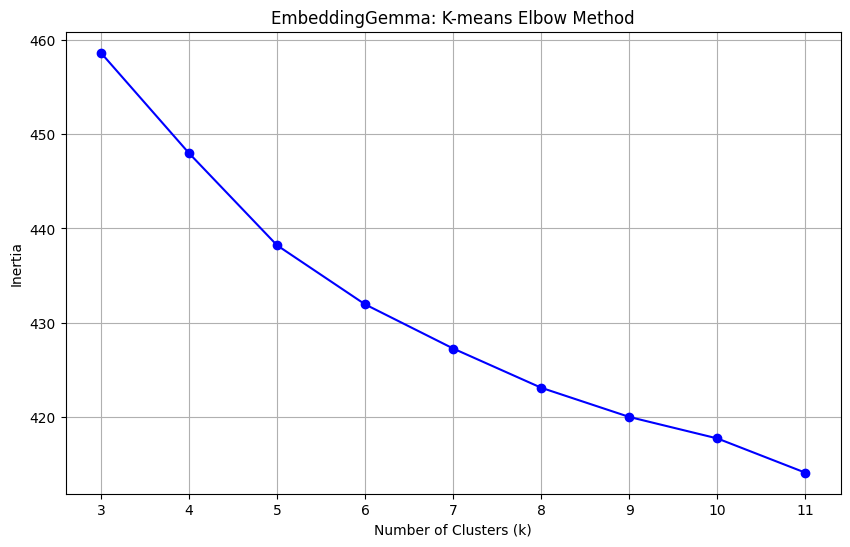

✅ K-means clustering completed with 6 clusters
📊 Cluster sizes:
   • Cluster 0: 135 articles
   • Cluster 1: 135 articles
   • Cluster 2: 231 articles
   • Cluster 3: 142 articles
   • Cluster 4: 114 articles
   • Cluster 5: 94 articles


In [11]:
# Perform K-means clustering
print("🔄 Performing K-means clustering on EmbeddingGemma embeddings...")

# Test different numbers of clusters
k_range = range(3, 12)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(embeddings_matrix)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'bo-')
plt.title('EmbeddingGemma: K-means Elbow Method')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Choose optimal k
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(embeddings_matrix)

df_embed['cluster'] = cluster_labels

print(f"✅ K-means clustering completed with {optimal_k} clusters")
print("📊 Cluster sizes:")
cluster_sizes = df_embed['cluster'].value_counts().sort_index()
for cluster_id, size in cluster_sizes.items():
    print(f"   • Cluster {cluster_id}: {size} articles")

In [12]:
# Visualize clusters
fig = px.scatter(
    df_embed,
    x='tsne_x',
    y='tsne_y',
    color='cluster',
    symbol='source_type',
    hover_data={'title': True, 'year': True, 'journal': True},
    title=f'EmbeddingGemma: t-SNE with {optimal_k} Clusters',
    width=900,
    height=700
)

fig.update_layout(title_x=0.5)
fig.show()

print("📊 EmbeddingGemma cluster visualization generated!")

📊 EmbeddingGemma cluster visualization generated!


## 9. Embedding Quality Analysis

In [13]:
# Analyze cluster characteristics
print("🔍 EmbeddingGemma CLUSTER ANALYSIS")
print("=" * 50)

for cluster_id in sorted(df_embed['cluster'].unique()):
    cluster_data = df_embed[df_embed['cluster'] == cluster_id]
    
    print(f"\n📊 Cluster {cluster_id} ({len(cluster_data)} publications):")
    print(f"   • IFC articles: {len(cluster_data[cluster_data['source_type'] == 'IFC'])}")
    print(f"   • PubMed articles: {len(cluster_data[cluster_data['source_type'] == 'PubMed'])}")
    
    # Year range
    years = cluster_data['year'].dropna()
    if len(years) > 0:
        print(f"   • Year range: {years.min()} - {years.max()}")
    
    # Top journals
    top_journals = cluster_data['journal'].value_counts().head(3)
    if len(top_journals) > 0:
        print(f"   • Top journals: {', '.join(top_journals.index[:3])}")
    
    # Sample titles
    sample_titles = cluster_data['title'].dropna().head(3)
    print(f"   • Sample titles:")
    for title in sample_titles:
        print(f"     - {title[:80]}...")

🔍 EmbeddingGemma CLUSTER ANALYSIS

📊 Cluster 0 (135 publications):
   • IFC articles: 0
   • PubMed articles: 135
   • Year range: 1992 - 2025
   • Top journals: PloS one, Veterinary research communications, mBio
   • Sample titles:
     - Comprehensive Biomarker Assessment of Pesticide Exposure and Telomere Attrition ...
     - Functional DEFB1 gene polymorphisms and synovial hBD-1 expression are associated...
     - Evaluating potentially toxic element accumulation in crops near abandoned mine t...

📊 Cluster 1 (135 publications):
   • IFC articles: 0
   • PubMed articles: 135
   • Year range: 1995 - 2025
   • Top journals: Nature, mBio, Frontiers in immunology
   • Sample titles:
     - A National Study of Somatotypes in Mexican Athletes Across 43 Sports....
     - Primary colonic lymphoma: clinical dilemmas in diagnosis and treatment strategy....
     - Cytotoxic Triterpene Glycosides from Mexican Sea Cucumber ...

📊 Cluster 2 (231 publications):
   • IFC articles: 0
   • PubMed ar

## 10. Performance Summary

In [14]:
# Final performance summary
print("\n🎯 EMBEDDINGGEMMA PERFORMANCE SUMMARY")
print("=" * 50)

print(f"📚 Dataset:")
print(f"   • Total articles processed: {len(df_embed)}")
print(f"   • IFC articles: {len(df_embed[df_embed['source_type'] == 'IFC'])}")
print(f"   • PubMed articles: {len(df_embed[df_embed['source_type'] == 'PubMed'])}")

print(f"\n🤖 Model Performance:")
print(f"   • Model: {model_id}")
print(f"   • Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"   • Embedding dimension: {gemma_embeddings.shape[1]}")
print(f"   • Processing device: {device}")
print(f"   • Processing speed: {len(gemma_embeddings)/processing_time:.1f} texts/second")
print(f"   • Total processing time: {processing_time/60:.1f} minutes")

print(f"\n🧮 Analysis Results:")
print(f"   • Clusters generated: {optimal_k}")
print(f"   • Dimensionality reduction: t-SNE + UMAP")
print(f"   • Visualization: Interactive plots")

print(f"\n💾 Storage:")
print(f"   • Embeddings file size: {os.path.getsize(gemma_embeddings_file) / 1e6:.1f} MB")
print(f"   • Completely offline after initial model download")
print(f"   • No API rate limits or costs")

print(f"\n✅ EmbeddingGemma testing completed successfully!")
print(f"🏠 Ready for offline, on-device embedding generation!")


🎯 EMBEDDINGGEMMA PERFORMANCE SUMMARY
📚 Dataset:
   • Total articles processed: 851
   • IFC articles: 0
   • PubMed articles: 851

🤖 Model Performance:
   • Model: google/embeddinggemma-300M
   • Parameters: 307,581,696
   • Embedding dimension: 768
   • Processing device: cuda
   • Processing speed: 3420.5 texts/second
   • Total processing time: 0.0 minutes

🧮 Analysis Results:
   • Clusters generated: 6
   • Dimensionality reduction: t-SNE + UMAP
   • Visualization: Interactive plots

💾 Storage:
   • Embeddings file size: 2.6 MB
   • Completely offline after initial model download
   • No API rate limits or costs

✅ EmbeddingGemma testing completed successfully!
🏠 Ready for offline, on-device embedding generation!


## 🚀 Next Steps

Now you have:

1. **✅ Working EmbeddingGemma Setup**: Completely offline embedding generation
2. **✅ Full Database Embeddings**: All IFC + PubMed articles embedded
3. **✅ Quality Analysis**: Clustering and visualization results
4. **✅ Performance Metrics**: Speed and resource usage data

### Comparison with Other Methods:
- **EmbeddingGemma**: High-quality, offline, 768D embeddings
- **Google Gemini API**: High-quality but rate-limited, requires internet
- **Local TF-IDF**: Fast but lower quality, 300D embeddings

### Use Cases:
- **Production environments** where internet access is limited
- **High-volume processing** without API costs
- **Privacy-sensitive applications** requiring local processing
- **Research applications** needing reproducible embeddings

The EmbeddingGemma embeddings can now be used for:
- Podcast episode generation
- Document similarity search
- Content recommendation systems
- Research topic analysis